In [1]:
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import sys, tqdm
from scipy.interpolate import interp1d, griddata
from matplotlib.collections import LineCollection

import numpy.ma as ma

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

sys.path.append('../pipeline_scripts/')
from pipeline_main import pipeline, sinks
from plotting_setup import *

In [3]:
data = pipeline(snap = 273, run = 'sink13fmr05', sink_id=13)
data.recalc_L(verbose = 1); data.calc_trans_xyz(verbose = 0)

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 4165/4165 [00:18<00:00, 223.50it/s]


Converged mean angular momentum vector after 0 iteration(s)


100%|██████████| 4165/4165 [00:01<00:00, 2953.27it/s]


In [4]:
shell_r=50; shell_Δpct=0.05

shell_r /= data.au_length
Δ_r = np.maximum(shell_Δpct * shell_r, 2.5 * 0.5 ** data.lmax) 

patch_coord = []
patch_values = []
patch_mass = []
cell_level = []

pp = [p for p in data.sn.patches if (p.dist_xyz < shell_r * 2).any() and p.level > 5]
w = np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]

for p in tqdm.tqdm(sorted_patches, disable=(not data.loading_bar)):
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position) ** 2).sum() < (p.size ** 2).sum() / 12]
    if len(leafs) == 8: continue
    to_extract = (p.dist_xyz < shell_r + Δ_r) & (p.dist_xyz > shell_r - Δ_r)
    for lp in leafs:
        leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
        covered_bool = ~np.all(((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None])), axis=0)
        to_extract *= covered_bool

    new_xyz = p.trans_xyz[:, to_extract].T
    new_value = (p.var('d') * np.sum((p.trans_vrel *  p.trans_xyz / np.linalg.norm(p.trans_xyz, axis=0)), axis=0))[to_extract].T
    mass = p.m[to_extract].T

    patch_values.extend(new_value.tolist())
    patch_mass.extend(mass.tolist())
    patch_coord.extend(new_xyz.tolist())
    cell_level.extend(p.level * np.ones(len(mass)))

patch_values = np.asarray(patch_values)
patch_mass = np.asarray(patch_mass)
cell_level = np.asarray(cell_level)
patch_coord = np.array(patch_coord)

100%|██████████| 961/961 [00:00<00:00, 1313.81it/s]


In [5]:
nside = 2; npix = hp.nside2npix(nside); m_data = np.zeros(npix)
print('Number of pixels on the sphere: ',npix)
pixel_indices = hp.vec2pix(nside, patch_coord[:,0], patch_coord[:,1], patch_coord[:,2])
index, counts = np.unique(pixel_indices, return_counts=True); 
m = np.zeros(npix)
m[index] = counts
print('Pixels without any representation: ', np.sum(m == 0))
print('Percentage of no-coverage: ', np.sum(m == 0) / npix * 100,'%' )

Number of pixels on the sphere:  48
Pixels without any representation:  0
Percentage of no-coverage:  0.0 %


In [6]:
cell_area = hp.nside2pixarea(nside) * shell_r**2
sum_value = np.bincount(pixel_indices, weights=patch_values) 
sum_count = np.bincount(pixel_indices)
map_clean = np.zeros(npix)
map_clean[sum_count > 0] = sum_value[sum_count > 0] / sum_count[sum_count > 0]

map_inter = map_clean.copy()
all_neighbours = hp.get_all_neighbours(nside, np.where(map_inter == 0))

for i, index in enumerate(np.where(map_inter == 0)[0]):
    non_zero_neighbours = all_neighbours[:,0,i] > 0
    map_inter[index] = np.average(map_inter[all_neighbours[:,0,i]], weights = non_zero_neighbours)

map_real = map_inter * -data.msun_mass / data.sn.cgs.yr * cell_area

In [7]:
bool_pos = map_real > 0; bool_neg = map_real < 0

inflow_pixels = map_real[bool_pos]
Lat, _ = hp.pix2ang(nside, np.arange(npix)[bool_pos])

infall_index = np.argsort(inflow_pixels)[::-1]
infall_index

array([10,  8, 11, 18, 22, 28, 17, 14, 23, 16, 15, 30, 26, 20, 32, 12, 21,
        1,  7, 13, 25, 19, 33, 27,  6,  3, 29, 35, 34, 31,  5,  2, 24,  4,
        9,  0])

In [8]:
sphere_area = cell_area * npix 

x = np.arange(len(inflow_pixels)) * cell_area / sphere_area * 100
y = np.cumsum(inflow_pixels[infall_index]) / np.sum(inflow_pixels) * 100

50 % of the accretion happens at 10.4% of the surface area
95 % of the accretion happens at 47.9% of the surface area


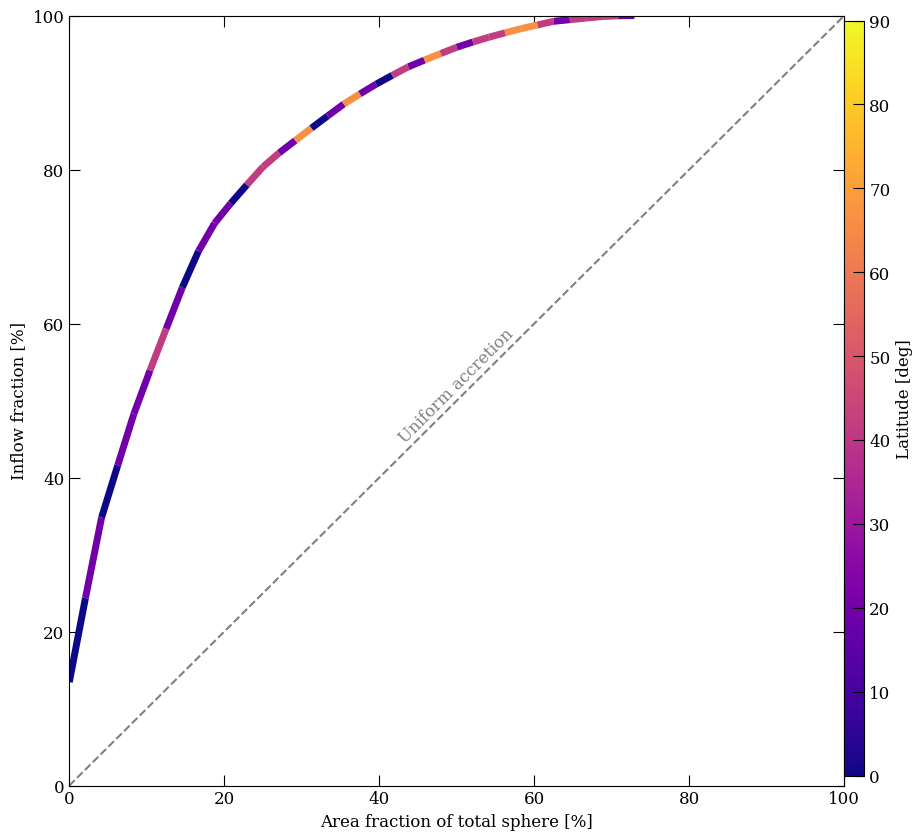

In [9]:
fig, axs = plt.subplots(figsize = (10,10))
axs.set(ylim = (0, 100), xlim = (0,100))

norm = plt.Normalize(0, 90)

#axs.plot(x,y)
uniform = np.linspace(0,100, 1000)
axs.text(50, 52, 'Uniform accretion', va = 'center', ha = 'center', rotation = 45, color = 'grey')
axs.plot(uniform, uniform, color = 'grey', ls = '--')
axs.set(xlabel = 'Area fraction of total sphere [%]', ylabel = 'Inflow fraction [%]')
get_50 = True
for j in range(len(y)):
    if y[j] > 50 and get_50: 
        print(f'50 % of the accretion happens at {x[j]:2.1f}% of the surface area')
        get_50 = False
    if y[j] > 95: 
        print(f'95 % of the accretion happens at {x[j]:2.1f}% of the surface area')
        break

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap='plasma', norm=norm)

lc.set_array(np.rad2deg(abs(Lat[infall_index] - np.pi / 2)))
lc.set_linewidth(5)

line = axs.add_collection(lc)
cbaxes = fig.add_axes([0.9, 0.12, 0.02, 0.755])
cbar = fig.colorbar(line, cax=cbaxes)
cbar.set_label('Latitude [deg]')